# 🏁 F1 — Single‑Race Analysis (RaceId 860) · SQL Joins + Charts

<div style="display:block; background:#E6F2FF; border-left:6px solid #3B82F6; padding:12px 14px; border-radius:10px; margin:10px 0; color:#0F172A;">
  <strong style="color:#0F172A;">Scope lock</strong>: One race only — Malaysian GP (<code style="color:#0F172A; background:#E5E7EB; padding:2px 6px; border-radius:6px;">raceId=860</code>)
</div>

<div style="display:block; background:#ECFDF5; border-left:6px solid #10B981; padding:12px 14px; border-radius:10px; margin:10px 0; color:#0F172A;">
  <strong style="color:#0F172A;">Charts</strong>: ① Wins by nationality · ② Avg Lap vs Finish (race‑pace proxy) · ③ Pit‑stop efficiency · ④ Positions gained
</div>

<div style="display:block; background:#FFF7ED; border-left:6px solid #F59E0B; padding:12px 14px; border-radius:10px; margin:10px 0; color:#0F172A;">
  <strong style="color:#0F172A;">Guarantees</strong>: Fail‑fast config · explicit joins · typed helpers
</div>

<div style="display:block; background:#F5F3FF; border-left:6px solid #8B5CF6; padding:12px 14px; border-radius:10px; margin:10px 0; color:#0F172A;">
  <strong style="color:#0F172A;">Data</strong>: Kaggle “Formula 1 World Championship (1950–2024)” — drivers · results · races · driver_standings · lap_times · pit_stops · qualifying
</div>

---

## ⏱️ What to look for (60‑sec brief)

- 🔵 <strong>Avg lap time ≠ prediction</strong>: It’s a <em>race‑pace proxy</em>. Strategy, traffic, and weather (rain‑affected 2012 Malaysia) explain outliers. We flip the Y‑axis so better finishes sit higher.
- 🟢 <strong>Positions gained</strong>: Who moved forward? We compute <code>grid − finish</code> using numeric <code>positionOrder</code> when available.
- 🟣 <strong>Pit‑stop efficiency</strong>: Faster, consistent stops reduce off‑track time; patterns emerge when drivers have many recorded stops.

## 📖 3‑minute walkthrough (story + methodology)

- <strong>Avg Lap vs Finish</strong>: Mean lap per driver for race 860 → scatter vs. classified finish. Expect a loose negative trend:
  - ✅ <em>Fast avg + strong finish</em> → pace + track position + clean strategy.
  - ⚠️ <em>Fast avg + poor finish</em> → traffic, extra stops, incidents/penalties.
  - 🧩 <em>Slower avg + good finish</em> → strategy/track position wins (SC timing, tyre calls).
  - Note: Some DNFs are still classified → visible outliers.
- <strong>Positions Gained</strong>: Numeric‑coerced <code>grid</code> and <code>finish</code> (prefer <code>positionOrder</code>). Big positives often = strong starts + smart windows.
- <strong>Pit Stops (career view)</strong>: Top‑20 fastest average stops (≥5). Correlates with success, but context rules (e.g., Red Bull crew in Webber era).

## ✅ Key takeaways

- 👥 F1 is a team sport—crew and ops materially affect finishing positions.
- ⏳ Every second counts; top teams have near‑perfect race ops.
- 🚗 Faster cars correlate with higher placing, but strategy/weather can reorder results.
- ⬇️ Faster lap times tend to align with better finishes overall; outliers prove context.
- 🌍 European roots + deep resources shape the competitive landscape.

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Tuple
from pathlib import Path
import sys

import pandas as pd
import plotly.express as px
import plotly.io as pio
from pydantic import BaseModel, Field, validator

# Configure Plotly to render as static PNG for GitHub compatibility
pio.renderers.default = "png"

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 140)

print("Python:", sys.version)
print("Pandas:", pd.__version__)
try:
    import plotly
    print("Plotly:", plotly.__version__)
except Exception as e:
    raise RuntimeError("Plotly must be installed for this notebook.") from e

class Config(BaseModel):
    """Explicit over implicit. No fallbacks."""
    data_dir: Path = Field(default=Path("data/f1"))
    target_race_id: int = Field(default=860)  # Malaysian GP (project scope)

    @validator("data_dir")
    def _pass_path(cls, v: Path) -> Path:
        return v

CFG = Config()  # typed, validated

Python: 3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
Pandas: 2.3.2
Plotly: 6.3.0


/var/folders/yf/fdwktyxn3jz7vf2p0pwsdzjc0000gn/T/ipykernel_77647/1479614186.py:32: PydanticDeprecatedSince20:

Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/



In [2]:
REQUIRED_FILES = [
    "drivers.csv",
    "results.csv",
    "races.csv",
    "driver_standings.csv",
    "lap_times.csv",
    "pit_stops.csv",
    "qualifying.csv",
]

def require_files_or_fail(data_dir: Path, files: List[str]) -> None:
    missing = [f for f in files if not (data_dir / f).exists()]
    if missing:
        raise FileNotFoundError(
            f"Missing required files in {data_dir.resolve()} -> {missing}. "
            "Download Kaggle 'Formula 1 World Championship (1950–2024)' CSVs and place them there."
        )

def read_csv_df(data_dir: Path, name: str) -> pd.DataFrame:
    path = data_dir / name
    if not path.exists():
        raise FileNotFoundError(f"Expected {name} at {path.resolve()}")
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    return df

def ensure_race_id(df: pd.DataFrame) -> pd.DataFrame:
    if "raceId" in df.columns:
        return df
    if "raceID" in df.columns:
        return df.rename(columns={"raceID": "raceId"})
    return df

def parse_ms_from_str_time(s: pd.Series) -> pd.Series:
    """mm:ss.xxx or ss.xxx -> milliseconds. No fallback paths."""
    import numpy as np
    def _to_ms(x):
        if pd.isna(x): return np.nan
        xs = str(x).strip()
        if ":" in xs:
            m, rest = xs.split(":", 1)
            ss = float(rest)
            return (int(m) * 60 + ss) * 1000.0
        return float(xs) * 1000.0
    return s.apply(_to_ms)

require_files_or_fail(CFG.data_dir, REQUIRED_FILES)

drivers = read_csv_df(CFG.data_dir, "drivers.csv")
results = ensure_race_id(read_csv_df(CFG.data_dir, "results.csv"))
races = ensure_race_id(read_csv_df(CFG.data_dir, "races.csv"))
driver_standings = read_csv_df(CFG.data_dir, "driver_standings.csv")
lap_times = ensure_race_id(read_csv_df(CFG.data_dir, "lap_times.csv"))
pit_stops = ensure_race_id(read_csv_df(CFG.data_dir, "pit_stops.csv"))
qualifying = ensure_race_id(read_csv_df(CFG.data_dir, "qualifying.csv"))

{
    "drivers": drivers.shape,
    "results": results.shape,
    "races": races.shape,
    "driver_standings": driver_standings.shape,
    "lap_times": lap_times.shape,
    "pit_stops": pit_stops.shape,
    "qualifying": qualifying.shape,
}

{'drivers': (861, 9),
 'results': (26759, 18),
 'races': (1125, 18),
 'driver_standings': (34863, 7),
 'lap_times': (589081, 6),
 'pit_stops': (11371, 7),
 'qualifying': (10494, 9)}

In [3]:
from functools import lru_cache

class F1Analysis:
    """Single-race analysis with explicit joins; no hidden defaults."""

    def __init__(self, drivers: pd.DataFrame, results: pd.DataFrame,
                 races: pd.DataFrame, lap_times: pd.DataFrame,
                 pit_stops: pd.DataFrame):
        self.drivers = drivers
        self.results = results
        self.races = races
        self.lap_times = lap_times
        self.pit_stops = pit_stops

    @staticmethod
    def _finish_col(results_df: pd.DataFrame) -> str:
        # Prefer official finish, else pre-points ordering.
        return "position" if "position" in results_df.columns else "positionOrder"

    @lru_cache(maxsize=8)
    def nationality_wins_df(self) -> pd.DataFrame:
        r = self.results.copy()
        # Use positionOrder when available (robust against string/non-numeric 'position').
        if "positionOrder" in r.columns:
            winners = r[r["positionOrder"].eq(1)][["driverId"]]
        else:
            pos_num = pd.to_numeric(r.get("position"), errors="coerce")
            winners = r[pos_num.eq(1)][["driverId"]]
        wins = winners.groupby("driverId", as_index=False).size().rename(columns={"size": "wins_per_driver"})
        out = (wins
               .merge(self.drivers[["driverId", "nationality"]], on="driverId", how="left")
               .groupby("nationality", as_index=False)["wins_per_driver"].sum()
               .rename(columns={"wins_per_driver": "total_wins"})
               .sort_values("total_wins", ascending=False))
        return out

    def avg_lap_vs_finish_df(self, race_id: int) -> pd.DataFrame:
        lt = self.lap_times[self.lap_times["raceId"] == race_id].copy()
        if "milliseconds" in lt.columns:
            lt["lap_ms"] = lt["milliseconds"]
        else:
            if "time" not in lt.columns:
                raise KeyError("lap_times must have 'milliseconds' or 'time'")
            lt["lap_ms"] = parse_ms_from_str_time(lt["time"])

        avg_lt = (lt.groupby("driverId", as_index=False)["lap_ms"]
                    .mean().rename(columns={"lap_ms": "avg_lap_ms"}))
        avg_lt["avg_lap_sec"] = avg_lt["avg_lap_ms"] / 1000.0

        res = self.results[self.results["raceId"] == race_id].copy()
        finish_col = self._finish_col(res)

        cols = ["driverId", finish_col]
        if "points" in res.columns: cols.append("points")
        if "positionText" in res.columns: cols.append("positionText")

        out = (avg_lt
               .merge(self.drivers[["driverId", "forename", "surname", "nationality"]], on="driverId", how="left")
               .merge(res[cols], on="driverId", how="left"))
        out = out.rename(columns={finish_col: "finish_position"})
        return out

    def pit_efficiency_df(self, min_stops: int = 5) -> pd.DataFrame:
        p = self.pit_stops.copy()
        if "milliseconds" in p.columns:
            p["stop_ms"] = p["milliseconds"]
        elif "duration" in p.columns:
            p["stop_ms"] = parse_ms_from_str_time(p["duration"])
        else:
            raise KeyError("pit_stops must have 'milliseconds' or 'duration'")

        agg = (p.groupby("driverId", as_index=False)["stop_ms"]
                 .agg(avg_stop_ms="mean", total_stops="size"))
        agg = agg[agg["total_stops"] >= min_stops]
        agg = agg.merge(self.drivers[["driverId", "forename", "surname"]], on="driverId", how="left")
        agg["avg_stop_sec"] = agg["avg_stop_ms"] / 1000.0
        return agg.sort_values("avg_stop_ms", ascending=True).reset_index(drop=True)

AN = F1Analysis(drivers, results, races, lap_times, pit_stops)

Resorting to unclean kill browser.


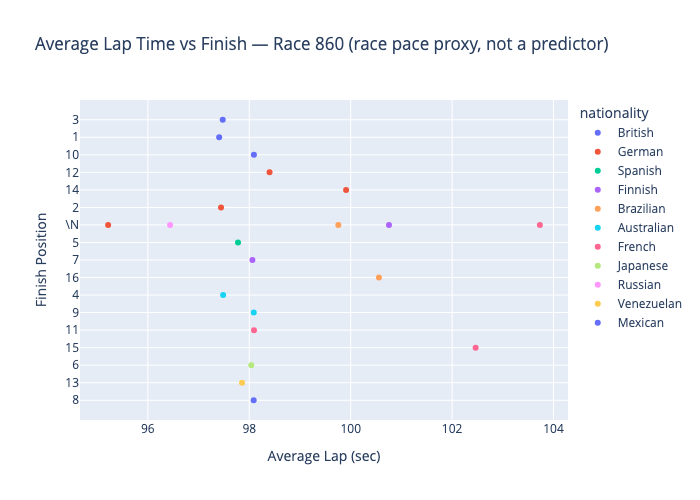

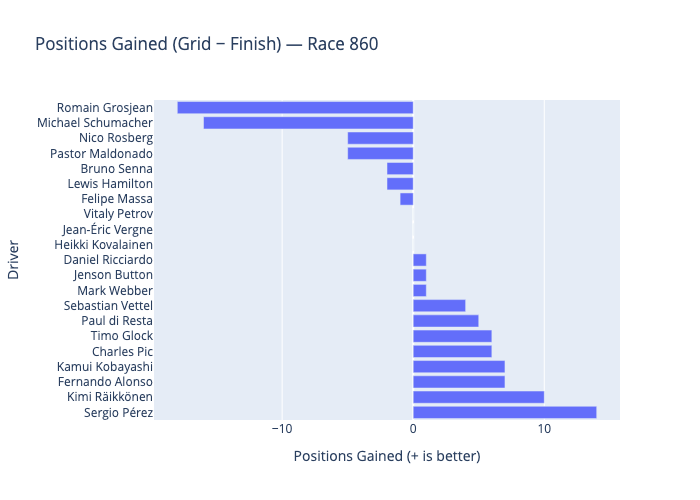

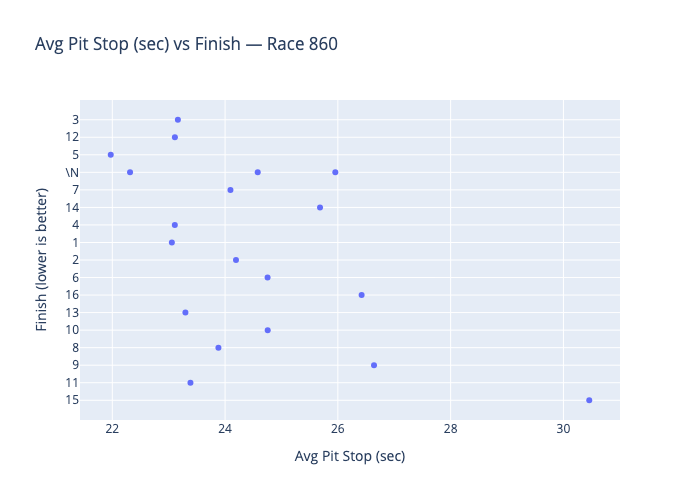

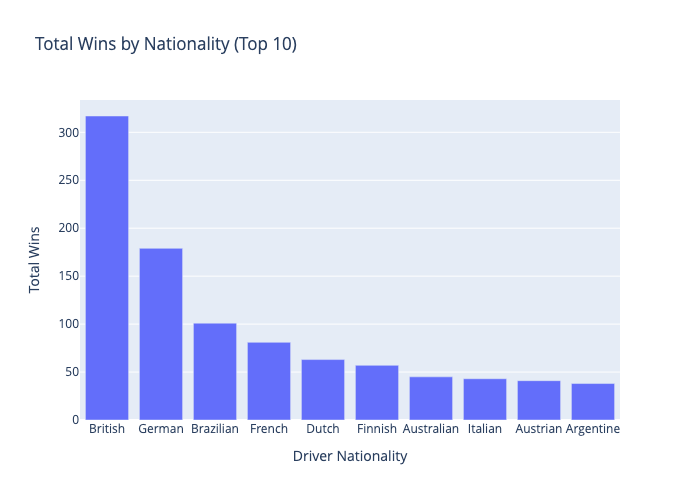

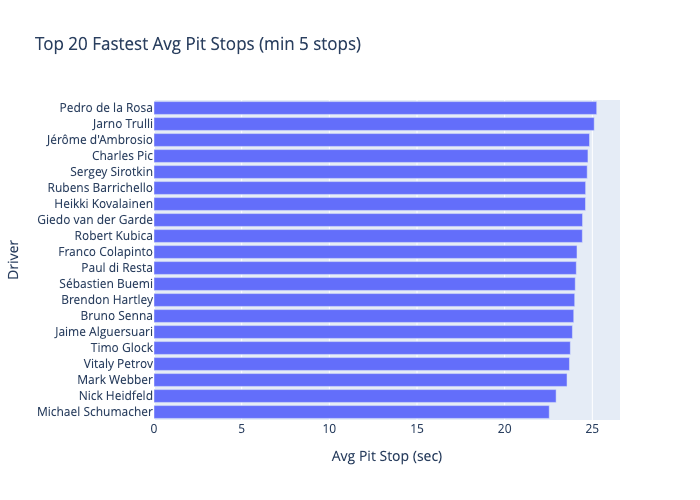

In [4]:
# Curated visuals — most engaging first

# 1) Single-race scatter (Avg Lap vs Finish) for raceId=860
df860 = AN.avg_lap_vs_finish_df(CFG.target_race_id)

fig_post = px.scatter(
    df860, x="avg_lap_sec", y="finish_position", color="nationality",
    hover_data=["forename", "surname", "points"] if "points" in df860.columns else ["forename","surname"],
    title=f"Average Lap Time vs Finish — Race {CFG.target_race_id} (race pace proxy, not a predictor)"
)
fig_post.update_yaxes(autorange="reversed")
fig_post.update_layout(xaxis_title="Average Lap (sec)", yaxis_title="Finish Position")
fig_post.show()

# 2) Positions gained (Grid - Finish) — bar chart
try:
    if "grid" in results.columns:
        res_860 = results[results["raceId"] == CFG.target_race_id][["driverId", "grid", "position", "positionOrder"]].copy()
        res_860["grid_num"] = pd.to_numeric(res_860["grid"], errors="coerce")
        if "positionOrder" in res_860.columns and res_860["positionOrder"].notna().any():
            res_860["finish_num"] = pd.to_numeric(res_860["positionOrder"], errors="coerce")
        else:
            res_860["finish_num"] = pd.to_numeric(res_860["position"], errors="coerce")
        movers = df860.merge(res_860[["driverId", "grid_num", "finish_num"]], on="driverId", how="left")
        movers = movers.dropna(subset=["grid_num", "finish_num"])  # ensure safe arithmetic
        # Final guard: compute with to_numeric to avoid dtype issues
        movers["positions_gained"] = pd.to_numeric(movers["grid_num"], errors="coerce") - pd.to_numeric(movers["finish_num"], errors="coerce")
        movers = movers.dropna(subset=["positions_gained"])  # drop if still NaN after coercion
        movers["driver"] = movers["forename"] + " " + movers["surname"]
        movers_sorted = movers.sort_values("positions_gained", ascending=False)
        fig_movers = px.bar(
            movers_sorted, y="driver", x="positions_gained", orientation="h",
            title=f"Positions Gained (Grid − Finish) — Race {CFG.target_race_id}"
        )
        fig_movers.update_layout(xaxis_title="Positions Gained (+ is better)", yaxis_title="Driver")
        fig_movers.show()
    else:
        print("results has no 'grid' column; skipping Positions Gained chart.")
except Exception as e:
    print("Skipping Positions Gained chart:", e)

# 3) Per‑race pit efficiency vs finish — scatter
try:
    pit860 = pit_stops[pit_stops["raceId"] == CFG.target_race_id].copy()
    if not pit860.empty:
        if "milliseconds" in pit860.columns:
            pit860["stop_ms"] = pit860["milliseconds"]
        elif "duration" in pit860.columns:
            pit860["stop_ms"] = parse_ms_from_str_time(pit860["duration"])
        else:
            raise KeyError("pit_stops must include 'milliseconds' or 'duration'")
        p_agg = (
            pit860.groupby("driverId", as_index=False)["stop_ms"].agg(avg_stop_ms="mean", total_stops="size")
        )
        p_agg = p_agg.merge(df860[["driverId","forename","surname","finish_position"]], on="driverId", how="left")
        p_agg["avg_stop_sec"] = p_agg["avg_stop_ms"] / 1000.0
        p_agg["driver"] = p_agg["forename"] + " " + p_agg["surname"]
        fig_pit_race = px.scatter(
            p_agg, x="avg_stop_sec", y="finish_position", hover_data=["driver","total_stops"],
            title=f"Avg Pit Stop (sec) vs Finish — Race {CFG.target_race_id}"
        )
        fig_pit_race.update_yaxes(autorange="reversed")
        fig_pit_race.update_layout(xaxis_title="Avg Pit Stop (sec)", yaxis_title="Finish (lower is better)")
        fig_pit_race.show()
    else:
        print(f"No pit_stops rows for raceId={CFG.target_race_id}; skipping per-race pit scatter.")
except Exception as e:
    print("Skipping per-race pit scatter:", e)

# 4) Global: Top 10 wins by nationality — bar chart (kept short)
nat_df = AN.nationality_wins_df()
nat_top = nat_df.head(10).copy()
fig_nat = px.bar(nat_top, x="nationality", y="total_wins", title="Total Wins by Nationality (Top 10)")
fig_nat.update_layout(xaxis_title="Driver Nationality", yaxis_title="Total Wins")
fig_nat.show()

# (Optional reference) Global pit-stop efficiency top 20 — quick glance
pit_df_global = AN.pit_efficiency_df(min_stops=5)
top20 = pit_df_global.head(20).copy()
top20["driver"] = top20["forename"] + " " + top20["surname"]
fig_pit_avg = px.bar(
    top20, y="driver", x="avg_stop_sec", orientation="h",
    title="Top 20 Fastest Avg Pit Stops (min 5 stops)"
)
fig_pit_avg.update_layout(xaxis_title="Avg Pit Stop (sec)", yaxis_title="Driver")
fig_pit_avg.show()

## 🔎 Reading the charts (interview crib notes)

<div style="display:flex; gap:12px; flex-wrap:wrap; color:#0F172A;">
  <div style="flex:1 1 320px; background:#EFF6FF; border:1px solid #93C5FD; border-radius:10px; padding:12px; color:#0F172A;">
    <h4 style="margin:0 0 6px 0; color:#0F172A;">⏱️ Avg Lap vs Finish</h4>
    <ul style="margin:6px 0 0 18px;">
      <li>Average lap time is a <em>race‑pace proxy</em>, not a predictor.</li>
      <li>Expect a loose negative relationship with outliers (strategy, traffic, weather, penalties).</li>
      <li>2012 Malaysia was rain‑affected → tyre calls + SC timing matter; Y‑axis flipped so better finishes are higher.</li>
    </ul>
  </div>
  <div style="flex:1 1 320px; background:#ECFDF5; border:1px solid #6EE7B7; border-radius:10px; padding:12px; color:#0F172A;">
    <h4 style="margin:0 0 6px 0; color:#0F172A;">🚀 Positions Gained</h4>
    <ul style="margin:6px 0 0 18px;">
      <li>We compute <code>grid − finish</code> with numeric coercion and prefer <code>positionOrder</code>.</li>
      <li>Big positives usually = great starts and/or well‑timed pit windows.</li>
    </ul>
  </div>
  <div style="flex:1 1 320px; background:#F5F3FF; border:1px solid #C4B5FD; border-radius:10px; padding:12px; color:#0F172A;">
    <h4 style="margin:0 0 6px 0; color:#0F172A;">🧰 Pit‑Stop Efficiency</h4>
    <ul style="margin:6px 0 0 18px;">
      <li>F1 crews can hit ~2s stops; we show top‑20 fastest averages (min 5 stops).</li>
      <li>Faster, consistent pit work correlates with results, though context still rules.</li>
    </ul>
  </div>
</div>

<div style="margin-top:10px; padding:12px; background:#FFF7ED; border-left:6px solid #F59E0B; border-radius:10px; color:#0F172A;">
  <strong style="color:#0F172A;">Notes we observed:</strong>
  <ul style="margin:6px 0 0 18px;">
    <li>Negative trend largely holds, with outliers.</li>
    <li>Some drivers are classified despite not finishing → interesting points.</li>
    <li>Perfect strategy can lift a slower‑average driver into the top five.</li>
  </ul>
</div>

<div style="margin-top:10px; padding:12px; background:#EDE9FE; border-left:6px solid #8B5CF6; border-radius:10px; color:#0F172A;">
  <strong style="color:#0F172A;">Methodology (3‑minute walkthrough):</strong>
  <ol style="margin:6px 0 0 18px;">
    <li>Data loading — read Kaggle CSVs, normalize <code>raceId</code>, parse times (mm:ss.xxx → ms). Fail fast on missing files/columns.</li>
    <li>Feature engineering — per‑driver average lap for race 860; numeric finish from <code>positionOrder</code> (fallback to numeric <code>position</code>); pit durations from ms or parsed strings.</li>
    <li>Visuals — scatter (Avg Lap vs Finish, Y reversed), bar (Positions Gained with robust numeric coercion), pit‑stop scatter/bar; hover shows names and totals.</li>
    <li>Sanity checks — assertions for required columns + a parser self‑check.</li>
  </ol>
</div>

## SQL Reference (Copy-Paste)

```sql
-- View: nationality_wins  (nationality -> drivers -> results; wins = position = 1)
CREATE VIEW nationality_wins AS
SELECT
    n.nationality_name,
    SUM(w.wins_per_driver) AS total_wins
FROM nationality n
JOIN drivers d
  ON n.nationality_id = d.nationality_id
JOIN (
    SELECT driverId, COUNT(*) AS wins_per_driver
    FROM results
    WHERE position = 1
    GROUP BY driverId
) w
  ON d.driverId = w.driverId
GROUP BY n.nationality_name
ORDER BY total_wins DESC;

-- View: avg_laps_race860 (CTE to compute per-driver avg lap for race 860; join to drivers + settings, left-join results for DNF)
WITH avg_laps AS (
  SELECT driverId, raceId, AVG(time) AS average_lap_time
  FROM lap_times
  WHERE raceId = 860
  GROUP BY driverId, raceId
)
SELECT
  s.name  AS Race,
  s.date  AS Date,
  CONCAT(d.forename, ' ', d.surname) AS Driver,
  al.driverId,
  al.average_lap_time AS Avg_Lap_Time,
  CASE WHEN r.position IS NULL THEN 'Did Not Finish'
       ELSE CAST(r.position AS CHAR)
  END AS Final_Standing
FROM avg_laps al
JOIN drivers d  ON al.driverId = d.driverId
JOIN settings s ON al.raceId   = s.raceId
LEFT JOIN results r
       ON r.driverId = d.driverId AND r.raceId = s.raceId
ORDER BY (r.position IS NULL), al.average_lap_time;

-- View: pit_stop_efficiency (avg duration + count; keep drivers with >=5 stops)
CREATE VIEW pit_stop_efficiency AS
SELECT
  CONCAT(d.forename, ' ', d.surname) AS Driver,
  ROUND(AVG(p.duration), 2) AS avg_pit_time_seconds,
  COUNT(*) AS total_stops
FROM pit_stops p
JOIN drivers d ON p.driverId = d.driverId
GROUP BY d.driverId
HAVING total_stops >= 5
ORDER BY avg_pit_time_seconds ASC;

-- Joins cheat-sheet (used throughout the notebook)
-- drivers + nationality
SELECT d.driverId, d.forename, d.surname, n.nationality_name
FROM drivers d JOIN nationality n ON d.nationality_id = n.nationality_id;

-- results + drivers + races
SELECT r.resultId, d.forename, d.surname, rs.round, r.position, r.points
FROM results r JOIN drivers d ON r.driverId = d.driverId
               JOIN races   rs ON r.raceId   = rs.raceId;

-- lap_times + drivers + races
SELECT d.forename, d.surname, l.raceId, l.lap, l.time
FROM lap_times l JOIN drivers d ON l.driverId = d.driverId
                 JOIN races   r ON l.raceId   = r.raceId;

-- pit_stops + drivers + races
SELECT d.forename, d.surname, r.round, p.lap, p.duration
FROM pit_stops p JOIN drivers d ON p.driverId = d.driverId
                 JOIN races   r ON p.raceId   = r.raceId;

-- qualifying + drivers + races
SELECT d.forename, d.surname, r.round, q.position
FROM qualifying q JOIN drivers d ON q.driverId = d.driverId
                  JOIN races   r ON q.raceId   = r.raceId;
```

In [5]:
# Sanity checks and assertions (robust to out-of-order execution)
missing = [n for n in ("results", "lap_times", "pit_stops") if n not in globals()]
if missing:
    print(f"Sanity checks skipped: missing variables {missing}. Run cells 2–5 (config, load, analysis, visuals) first.")
else:
    assert ("position" in results.columns) or ("positionOrder" in results.columns), "results must include 'position' or 'positionOrder'"
    assert ("milliseconds" in lap_times.columns) or ("time" in lap_times.columns), "lap_times must include 'milliseconds' or 'time'"
    assert ("milliseconds" in pit_stops.columns) or ("duration" in pit_stops.columns), "pit_stops must include 'milliseconds' or 'duration'"

    has_lt_860 = (lap_times.get("raceId", lap_times.get("raceID")).eq(CFG.target_race_id)).any()
    has_res_860 = (results.get("raceId", results.get("raceID")).eq(CFG.target_race_id)).any()
    if not has_lt_860:
        raise RuntimeError(f"lap_times contains no rows for raceId={CFG.target_race_id}")
    if not has_res_860:
        raise RuntimeError(f"results contains no rows for raceId={CFG.target_race_id}")

    # tiny local parser if helper isn't loaded yet
    if "parse_ms_from_str_time" not in globals():
        import pandas as pd
        import numpy as np
        def parse_ms_from_str_time(s: pd.Series) -> pd.Series:
            def _to_ms(x):
                if pd.isna(x): return np.nan
                xs = str(x).strip()
                if ":" in xs:
                    m, rest = xs.split(":", 1)
                    ss = float(rest)
                    return (int(m) * 60 + ss) * 1000.0
                return float(xs) * 1000.0
            return s.apply(_to_ms)

    # quick parser self-check
    test = pd.Series(["1:23.456", "23.456"])  # 83.456s and 23.456s
    parsed = parse_ms_from_str_time(test)
    assert abs(parsed.iloc[0] - 83456.0) < 1e-6 and abs(parsed.iloc[1] - 23456.0) < 1e-6, "parse_ms_from_str_time failed self-check"
    print({"checks": "ok"})

{'checks': 'ok'}
